# Analysis example and plotting tutorial

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pyemma
from mcmm.example import generate_test_data

plt.rc('font', size=15)

Here, we define a function to add often used properties to a matplotlib axis object.

In [2]:
def format_square(ax):
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_xticks([-2, -1, 0, 1, 2])
    ax.set_yticks([-2, -1, 0, 1, 2])
    ax.set_xlabel(r"$x$ / a.u.")
    ax.set_ylabel(r"$y$ / a.u.")
    ax.set_aspect('equal')

## Data generation

We start by calling the data generation function from the example module.

In [3]:
raw_data = generate_test_data(num_trajs=20, traj_length=20000)

`raw_data` is a list of 2D numpy ndarrays which we visualise as a scatter plot. You can also try to plot the $x$-/$y$-components as time series.

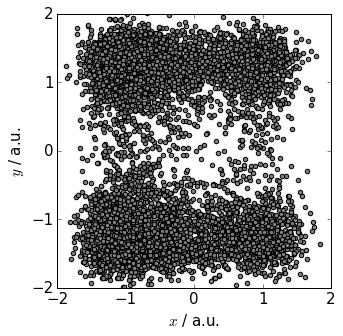

In [4]:
fig, ax = plt.subplots(figsize=(5, 5))
for rd in raw_data:
    ax.scatter(rd[::50, 0], rd[::50, 1], c='grey', s=20)
format_square(ax)
fig.tight_layout()

## Clustering and discretisation

This example uses `pyemma`, but your `mcmm` nodule must be able to to the same.

In [5]:
cluster = pyemma.coordinates.cluster_kmeans(data=raw_data, k=100, max_iter=100)
centers = cluster.clustercenters
dtrajs = cluster.dtrajs

30-06-16 14:25:22 pyemma.coordinates.clustering.kmeans.KmeansClustering[0] INFO     Cluster centers converged after 34 steps.


We extend our scatter plot of the raw data by adding the cluster centers.

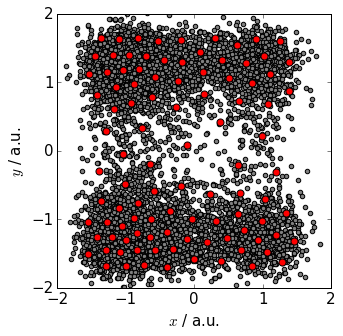

In [6]:
fig, ax = plt.subplots(figsize=(5, 5))
for rd in raw_data:
    ax.scatter(rd[::50, 0], rd[::50, 1], c='grey', s=20)
ax.scatter(centers[:, 0], centers[:, 1], c='red', s=50)
format_square(ax)
fig.tight_layout()

## Estimation and timescales

This is where we start to estimate transition matrices. In order to find a good lagtime, we can estimate several transition matrices for different lagtimes and look at the timescales. Once they are converged, we might have found a suitable lagtime.

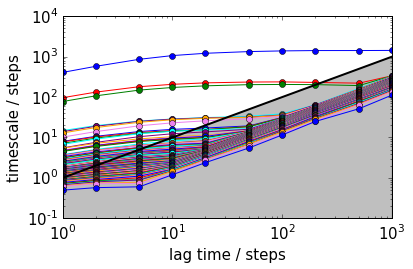

In [7]:
ax = pyemma.plots.plot_implied_timescales(
    pyemma.msm.its(dtrajs=dtrajs, lags=[1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]),
    xlog=True, marker='o')
ax.figure.tight_layout()

Now we have to decide on a lagtime and estimate the MSM. A further Chapman-Kolmogoroff test can tell us more about the suitability of the chosen lagtime.

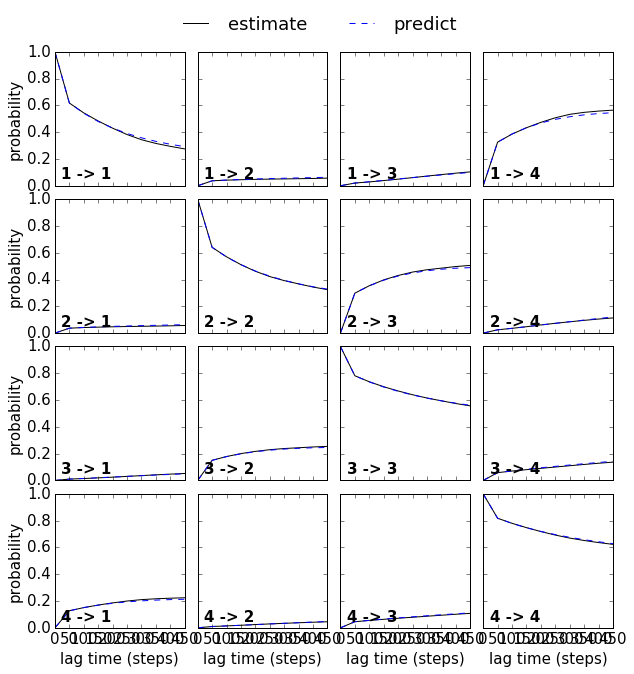

In [8]:
msm = pyemma.msm.estimate_markov_model(dtrajs=dtrajs, lag=50)

fig, axes = pyemma.plots.plot_cktest(msm.cktest(4))

## Analysis

Let's learn something about our system. We start by looking at the stationary distribution $\pi$, which can be visualised as a colored scatter plot of the cluster centers.

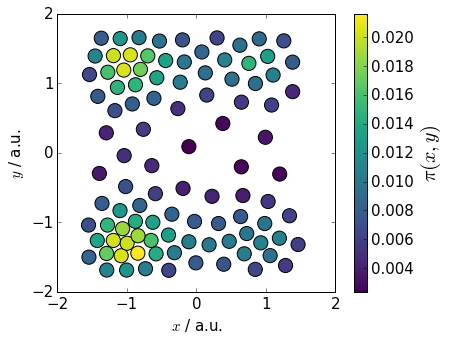

In [9]:
fig, ax = plt.subplots(figsize=(6.5, 5))
im = ax.scatter(centers[:, 0], centers[:, 1], c=msm.stationary_distribution, s=200, cmap=mpl.cm.viridis)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r"$\pi(x,y)$", fontsize=20)
format_square(ax)
fig.tight_layout()

In the same way, we can visualise, e.g., some of the right eigenvectors.

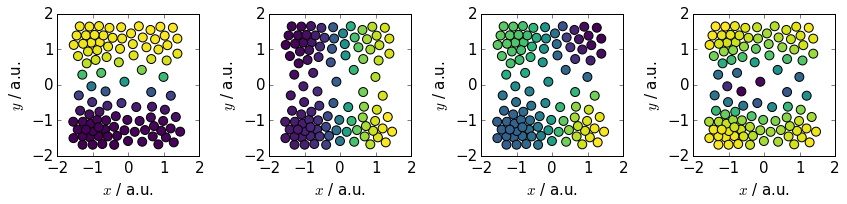

In [10]:
rev = msm.eigenvectors_right(k=5)

fig, axes = plt.subplots(1, 4, figsize=(12, 3.5))
for i, ax in enumerate(axes.flat):
    ax.scatter(centers[:, 0], centers[:, 1], s=80, c=rev[:, i+1], cmap=mpl.cm.viridis)
    format_square(ax)
fig.tight_layout()

Now it's useful to start coarse graining our system into metastable states with PCCA++. The assignments can, again, be visualised as a colored scatter plot.

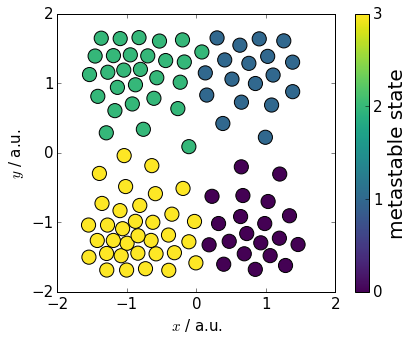

In [13]:
n_pcca_states = 4

msm.pcca(n_pcca_states)

fig, ax = plt.subplots(figsize=(6.5, 5))
im = ax.scatter(centers[:, 0], centers[:, 1], c=msm.metastable_assignments, s=200, cmap=mpl.cm.viridis)
cbar = fig.colorbar(im, ax=ax)
cbar.set_ticks(np.arange(n_pcca_states))
cbar.set_label(r"metastable state", fontsize=20)
format_square(ax)
fig.tight_layout()

We compute the stationary probabilities of the metastable states and use this as new coloring for the scatter plot.

[ 0.14719104  0.14601026  0.31058751  0.39621119]


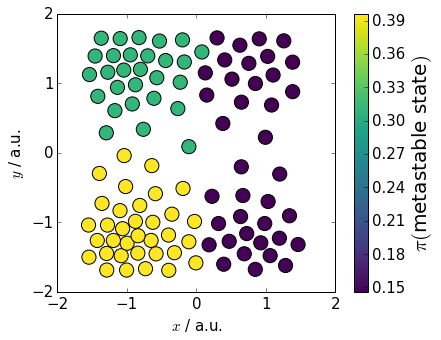

In [14]:
pi = np.array([msm.stationary_distribution[s].sum() for s in msm.metastable_sets])
pi_vec = pi[msm.metastable_assignments]

fig, ax = plt.subplots(figsize=(6.5, 5))
im = ax.scatter(centers[:, 0], centers[:, 1], c=pi_vec, s=200, cmap=mpl.cm.viridis)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r"$\pi($metastable state$)$", fontsize=20)
format_square(ax)
fig.tight_layout()

print pi

Finally, we compute mean first passage times (MFPTs) and draw a graph where the size of the nodes is proportional to the stationary probabilities of the metastable states and the thickness of the arrows indicates how fast a transition can occur on average. The actual MFPT values are used as labels for the arrows.

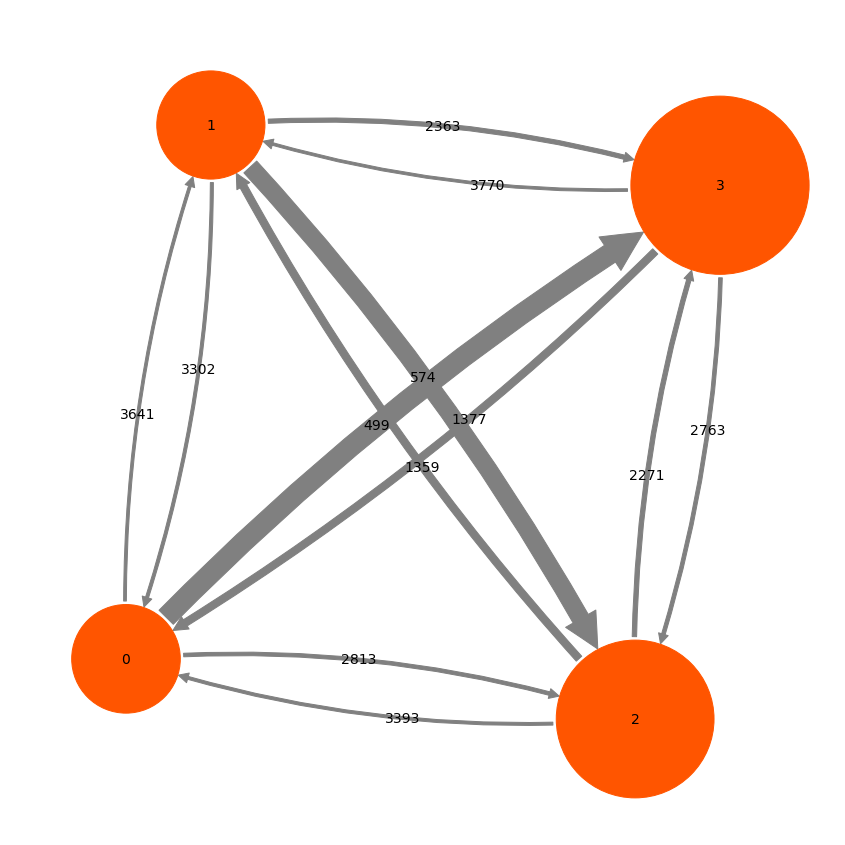

In [15]:
mfpt = np.zeros(shape=(n_pcca_states, n_pcca_states))
for i, s1 in enumerate(msm.metastable_sets):
    for j, s2 in enumerate(msm.metastable_sets):
        if s1 is s2: continue
        mfpt[i, j] = msm.mfpt(s1, s2)

arrow_weights = mfpt.copy()
nz = mfpt.nonzero()
arrow_weights[nz] = 1.0 / arrow_weights[nz]

fig, pos = pyemma.plots.plot_network(
    arrow_weights, xpos=[1, 1.5, 4, 4.5], state_sizes=pi,
    arrow_labels=mfpt, arrow_label_format="%.0f", arrow_scale=2.0)
fig.tight_layout()